# Deep Learning NER task

Tatjana Cucic and Sanna Volanen

https://spacy.io/api/annotation

# Milestones

## 1.1 Predicting word labels independently

* The first part is to train a classifier which assigns a label for each given input word independently. 
* Evaluate the results on token level and entity level. 
* Report your results with different network hyperparameters. 
* Also discuss whether the token level accuracy is a reasonable metric.









In [0]:
# Training data: Used for training the model
!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/train.tsv

# Development/ validation data: Used for testing different model parameters, for example level of regularization needed
!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/dev.tsv

# Test data: Never touched during training / model development, used for evaluating the final model
!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/data/test.tsv

#saved model
#!wget -nc https://raw.githubusercontent.com/sainvo/DeepLearning_NER/master/saved_models/Adamax90.h5



In [49]:
import sys 
import csv

csv.field_size_limit(sys.maxsize)

9223372036854775807

In [0]:
#read tsv data to list of lists of lists: a list of sentences that contain lists of tokens that are lists of unsplit \t lines from the tsv, such as ['attract\tO']
token = {"word":"","entity_label":""}

def read_ontonotes(tsv_file): # 
    current_sent = [] # list of (word,label) lists
    with open(tsv_file) as f:
        tsvreader = csv.reader(f, delimiter= '\n')
        for line in tsvreader:
            #print(line)
            if not line:
                if current_sent:
                    yield current_sent
                    current_sent=[]
                continue
            current_sent.append(line[0]) 
        else:
            if current_sent:
                yield current_sent

train_data_full = list(read_ontonotes('train.tsv'))
dev_data_full = list(read_ontonotes('dev.tsv'))
test_data_full = list(read_ontonotes('test.tsv'))

In [50]:
import re
from pprint import pprint
#regex for empty space chars, \t \n
#tab = re.compile('[\t]')
#line = re.compile('[\n]')
punct = re.compile('[.?!:;]')

def splitter(sent):
    #print('----------------------------------------')
    #print("one sentence in raw data:", sent)
    split_list = []
    # loop over tokens items inside sentence, supposedly item= token+ \t +tag
    for item in sent: 
        #print("Item in sentence: ", item)
        if item != None:
            match1 = item.count('\n')
            #print(match1)
            match2 = item.count('\t')
            #print(match2)
            if match1 ==0: # no new lines nested
                if match2 == 1: #just one tab inside token
                    item_pair = item.split('\t')
                if item_pair[0] =='': # replacing empty string with missing quote marks
                    item_pair[0] = '\"'
                split_list.append(item_pair) 
            else:
                subitems_list = item.split('\n') ## check if token has \n -> bundled, quotes
                if len(subitems_list) > 1:  ## item string has more than one sentence nested in it
                    #print("Found nested sentences: ", subitems_list)
                    #print("subseq start")
                    for j in range(len(subitems_list)):  
                        token = subitems_list[j]  
                        #print(token)
                        subtoken_listed_again = token.split('\n') 
                        for token in subtoken_listed_again:
                            match1=token.count('\n')
                            match2=token.count('\t')
                            if  match1 == 0: # no new lines nested
                               if  match2 == 1: #just one tab inside token
                                    token = token.split('\t')
                            if token =='': # replacing empty string with missing quote marks
                                token = '\"'
                            if token == '.':
                                split_list.append(token)
                                continue
                                split_list=[]
                            else:
                                split_list.append(token)
                    #print("subseq end")
    for item in split_list:
        #print("Item in split list: ",item)
        if type(item) != list:
            split_list.remove(item)
        if item[0] =='': # replacing empty string with missing quote marks
            item[0] = '\"'
    #print("Resplitted sentence :", split_list)
    return split_list

def clean(raw_data): ## input list is list of lists of strings 
    clean_data =[]  #list of lists that have one clean sentence per list
    for sent in raw_data: # split by [] lines, supposedly a sentence line
        one_sentence = [] #collects the new sentence if there has been need to resplit items
        splitted= splitter(sent)
        for item in splitted:
            #print(item)
            matchi = re.match(punct, item[0])
            if matchi:
                #print("collected sentence")
                one_sentence.append(item)
                clean_data.append(one_sentence)
                one_sentence=[]
                break
            else:
                one_sentence.append(item)

    return clean_data

train_data_clean = clean(train_data_full)
print(len(train_data_clean))
for item in train_data_clean[:3]:
    print(item)

50252
[['In', 'O'], ['recent', 'B-DATE'], ['years', 'I-DATE'], [',', 'O'], ['advanced', 'O'], ['education', 'O'], ['for', 'O'], ['professionals', 'O'], ['has', 'O'], ['become', 'O'], ['a', 'O'], ['hot', 'O'], ['topic', 'O'], ['in', 'O'], ['the', 'O'], ['business', 'O'], ['community', 'O'], ['.', 'O']]
[['With', 'O'], ['this', 'O'], ['trend', 'O'], [',', 'O'], ['suddenly', 'O'], ['the', 'O'], ['mature', 'O'], ['faces', 'O'], ['of', 'O'], ['managers', 'O'], ['boasting', 'O'], ['an', 'O'], ['average', 'O'], ['of', 'O'], ['over', 'O'], ['ten', 'B-DATE'], ['years', 'I-DATE'], ['of', 'O'], ['professional', 'O'], ['experience', 'O'], ['have', 'O'], ['flooded', 'O'], ['in', 'O'], ['among', 'O'], ['the', 'O'], ['young', 'O'], ['people', 'O'], ['populating', 'O'], ['university', 'O'], ['campuses', 'O'], ['.', 'O']]
[['In', 'O'], ['order', 'O'], ['to', 'O'], ['attract', 'O'], ['this', 'O'], ['group', 'O'], ['of', 'O'], ['seasoned', 'O'], ['adults', 'O'], ['pulling', 'O'], ['in', 'O'], ['over', 'O

In [51]:
# final check on the sentences
item_lengths = []
max_text = 0
max_ind=0
for item in train_data_clean:
    item_lengths.append(len(item))
    if len(item) > max_text:
        max_text = len(item)
        max_ind = train_data_clean.index(item)
print("Longest sentence:", max_text, "index: ",max_ind)

lengths_sorted = sorted(item_lengths, reverse=True)
max = item_lengths.index(max_text)

#pprint(train_data_clean[max])
print(lengths_sorted[:300]) # longest sentences


Longest sentence: 168 index:  8041
[168, 145, 123, 121, 120, 108, 106, 106, 102, 101, 97, 96, 94, 94, 93, 93, 93, 92, 91, 91, 91, 90, 90, 90, 90, 90, 90, 89, 88, 88, 88, 87, 87, 86, 85, 85, 85, 85, 84, 84, 84, 84, 83, 83, 83, 83, 82, 82, 82, 82, 81, 81, 80, 80, 80, 79, 79, 79, 79, 79, 79, 78, 78, 78, 78, 78, 77, 77, 77, 77, 77, 77, 77, 77, 76, 76, 76, 76, 76, 76, 76, 76, 76, 75, 75, 75, 75, 75, 75, 75, 75, 75, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 71, 71, 71, 71, 71, 71, 71, 71, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64

In [52]:
# pop the longest
train_data_clean.pop(max_ind)
print(len(train_data_clean))

50251


In [53]:

print('------------------------------------------')
dev_data_clean = clean(dev_data_full)
print(len(dev_data_clean))
for item in dev_data_clean[:3]:
    print(item)
print('------------------------------------------')
test_data_clean = clean(test_data_full)
print(len(test_data_clean))
for item in test_data_clean[:3]:
    print(item)
print('------------------------------------------')    

------------------------------------------
9954
[['President', 'O'], ['Chen', 'B-PERSON'], ['Shui', 'I-PERSON'], ['-', 'I-PERSON'], ['bian', 'I-PERSON'], ['visited', 'O'], ['the', 'B-FAC'], ['Nicaraguan', 'I-FAC'], ['National', 'I-FAC'], ['Assembly', 'I-FAC'], ['on', 'O'], ['August', 'B-DATE'], ['17', 'I-DATE'], [',', 'O'], ['where', 'O'], ['he', 'O'], ['received', 'O'], ['a', 'O'], ['medal', 'O'], ['from', 'O'], ['the', 'O'], ['president', 'O'], ['of', 'O'], ['the', 'O'], ['assembly', 'O'], [',', 'O'], ['Ivan', 'B-PERSON'], ['Escobar', 'I-PERSON'], ['Fornos', 'I-PERSON'], ['.', 'O']]
[['On', 'O'], ['August', 'B-DATE'], ['25', 'I-DATE'], ['President', 'O'], ['Chen', 'B-PERSON'], ['Shui', 'I-PERSON'], ['-', 'I-PERSON'], ['bian', 'I-PERSON'], ['wrapped', 'O'], ['up', 'O'], ['his', 'O'], ['first', 'B-ORDINAL'], ['overseas', 'O'], ['trip', 'O'], ['since', 'O'], ['taking', 'O'], ['office', 'O'], [',', 'O'], ['swinging', 'O'], ['through', 'O'], ['three', 'B-CARDINAL'], ['countries', 'O'], ['

In [54]:
# shape into dicts per sentence

def reshape_sent2dicts(f):
    data_dict = []
    for item in f: # list of lists (tokens)
        #print(item)
        sent_text= [] 
        sent_tags = []
        for token in item:
            if len(token) ==2:
                sent_text.append(token[0])
                sent_tags.append(token[1])
        sent_dict = {'text':sent_text,'tags':sent_tags }
        #print(sent_dict['text'])
        #print(sent_dict['tags'])
        data_dict.append(sent_dict)
    return data_dict

train_data_sent = list(reshape_sent2dicts(train_data_clean))
samp = train_data_sent[:2]
print(samp)
print()
dev_data_sent = list(reshape_sent2dicts(dev_data_clean))
samp2 = dev_data_sent[:3]
print(samp2)
test_data_sent = list(reshape_sent2dicts(test_data_clean))
samp3 = test_data_sent[:3]
print(samp3)

[{'text': ['In', 'recent', 'years', ',', 'advanced', 'education', 'for', 'professionals', 'has', 'become', 'a', 'hot', 'topic', 'in', 'the', 'business', 'community', '.'], 'tags': ['O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}, {'text': ['With', 'this', 'trend', ',', 'suddenly', 'the', 'mature', 'faces', 'of', 'managers', 'boasting', 'an', 'average', 'of', 'over', 'ten', 'years', 'of', 'professional', 'experience', 'have', 'flooded', 'in', 'among', 'the', 'young', 'people', 'populating', 'university', 'campuses', '.'], 'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}]

[{'text': ['President', 'Chen', 'Shui', '-', 'bian', 'visited', 'the', 'Nicaraguan', 'National', 'Assembly', 'on', 'August', '17', ',', 'where', 'he', 'received', 'a', 'medal', 'from', 'the', 'president', 'of', 'the', 'assembly', ',', 'Ivan', 

In [55]:
import random
import numpy

random.seed(125)
random.shuffle(train_data_sent)
#max_sent = [max(len(i["text"])) for i in train_data_sent]
#print(max_sent)
print(type(train_data_sent))
print(train_data_sent[0]) ##one dict
print()
print(train_data_sent[0]["text"])
print()
print(train_data_sent[0]["tags"])
print('------------')

def typed_listing(data, key):
    listed = []
    max_length = 0
    for item in data: # dictionary {text:"", tags:""}
        #print('Item: ', item)
        #print('Key: ', key, ' content: ', item[key], 'length: ',len(item[key]))
        if len(item[key]) > max_length:
            max = len(item[key])
        listed.append(item[key])
    return listed, max_length

listed_texts= typed_listing(train_data_sent, "text")
train_texts = listed_texts[0]
train_txt_max = listed_texts[1]
listed_labels = typed_listing(train_data_sent, "tags")
train_labels= listed_labels[0]
train_lbl_max = listed_labels[1]
print(train_txt_max)
print(train_texts[0])
print(train_labels[0])


print('-----------------------------')
print(len(train_texts))
print('-----------------------')
print('Text: ', train_texts[0])
print(' Texts length: ',len(train_texts))
print('Label: ', train_labels[0])
print(' Labels length: ',len(train_labels))


<class 'list'>
{'text': ['But', 'the', 'Bush', 'administration', '``', 'has', 'abdicated', 'that', 'obligation', ',', "''", 'says', 'Frelick', '.'], 'tags': ['O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O']}

['But', 'the', 'Bush', 'administration', '``', 'has', 'abdicated', 'that', 'obligation', ',', "''", 'says', 'Frelick', '.']

['O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O']
------------
0
['But', 'the', 'Bush', 'administration', '``', 'has', 'abdicated', 'that', 'obligation', ',', "''", 'says', 'Frelick', '.']
['O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O']
-----------------------------
50251
-----------------------
Text:  ['But', 'the', 'Bush', 'administration', '``', 'has', 'abdicated', 'that', 'obligation', ',', "''", 'says', 'Frelick', '.']
 Texts length:  50251
Label:  ['O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', '

In [56]:
## same for validation/dev data
listed_texts_dev = typed_listing(dev_data_sent, "text")
dev_texts = listed_texts_dev[0]
dev_txt_max = listed_texts_dev[1]

listed_labels_dev = typed_listing(dev_data_sent, "tags")
dev_labels= listed_labels_dev[0]
dev_lbl_max = listed_labels_dev[1]

print('Text: ', dev_texts[0])
print(' Texts length: ',len(dev_texts))
print('Label: ', dev_labels[0])
print(' Labels length: ',len(dev_labels))

##and test data
print("length of test data: ",len(test_data_sent))
listed_texts_test = typed_listing(test_data_sent, "text")
test_texts = listed_texts_test[0]
test_txt_max = listed_texts_test[1]
print("Length of test texts: ",test_txt_max) # for some reason colab gives zero?
print("first item of text texts: ",test_texts[0])
listed_labels_test = typed_listing(test_data_sent, "tags")
test_labels= listed_labels_test[0]
test_lbl_max = listed_labels_test[1]
print("Length of test labels: ",test_lbl_max) # for some reason colab gives zero?
print(test_texts[:2])

Text:  ['President', 'Chen', 'Shui', '-', 'bian', 'visited', 'the', 'Nicaraguan', 'National', 'Assembly', 'on', 'August', '17', ',', 'where', 'he', 'received', 'a', 'medal', 'from', 'the', 'president', 'of', 'the', 'assembly', ',', 'Ivan', 'Escobar', 'Fornos', '.']
 Texts length:  9954
Label:  ['O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'B-FAC', 'I-FAC', 'I-FAC', 'I-FAC', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O']
 Labels length:  9954
length of test data:  7920
Length of test texts:  0
first item of text texts:  ['The', 'enterovirus', 'detection', 'biochip', 'developed', 'by', 'DR.', 'Chip', 'Biotechnology', 'takes', 'only', 'six', 'hours', 'to', 'give', 'hospitals', 'the', 'answer', 'to', 'whether', 'a', 'sample', 'contains', 'enterovirus', ',', 'and', 'if', 'it', 'is', 'the', 'deadly', 'strain', 'Entero', '71', '.']
Length of test labels:  0
[['The', 'enterovirus', 'detection', 'bi

In [0]:
# Load pretrained embeddings
!wget -nc https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


In [0]:
# Give -n argument so that a possible existing file isn't overwritten 
!unzip -n wiki-news-300d-1M.vec.zip

In [57]:
from gensim.models import KeyedVectors

vector_model = KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary=False, limit=50000)


# sort based on the index to make sure they are in the correct order
words = [k for k, v in sorted(vector_model.vocab.items(), key=lambda x: x[1].index)]
print("Words from embedding model:", len(words))
print("First 50 words:", words[:50])

# Normalize the vectors to unit length
print("Before normalization:", vector_model.get_vector("in")[:10])
vector_model.init_sims(replace=True)
print("After normalization:", vector_model.get_vector("in")[:10])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Words from embedding model: 50000
First 50 words: [',', 'the', '.', 'and', 'of', 'to', 'in', 'a', '"', ':', ')', 'that', '(', 'is', 'for', 'on', '*', 'with', 'as', 'it', 'The', 'or', 'was', "'", "'s", 'by', 'from', 'at', 'I', 'this', 'you', '/', 'are', '=', 'not', '-', 'have', '?', 'be', 'which', ';', 'all', 'his', 'has', 'one', 'their', 'about', 'but', 'an', '|']
Before normalization: [-0.0234 -0.0268 -0.0838  0.0386 -0.0321  0.0628  0.0281 -0.0252  0.0269
 -0.0063]
After normalization: [-0.0163762  -0.01875564 -0.05864638  0.02701372 -0.02246478  0.04394979
  0.01966543 -0.0176359   0.01882563 -0.00440898]


In [58]:
# Build vocabulary mappings

# Zero is used for padding in Keras, prevent using it for a normal word.
# Also reserve an index for out-of-vocabulary items.
vocabulary={
    "<PAD>": 0,
    "<OOV>": 1
}

for word in words: # These are words from the word2vec model
    vocabulary.setdefault(word, len(vocabulary))

print("Words in vocabulary:",len(vocabulary))
inv_vocabulary = { value: key for key, value in vocabulary.items() } # invert the dictionary


# Embedding matrix
def load_pretrained_embeddings(vocab, embedding_model):
    """ vocab: vocabulary from our data vectorizer, embedding_model: model loaded with gensim """
    pretrained_embeddings = numpy.random.uniform(low=-0.05, high=0.05, size=(len(vocab)-1,embedding_model.vectors.shape[1]))
    pretrained_embeddings = numpy.vstack((numpy.zeros(shape=(1,embedding_model.vectors.shape[1])), pretrained_embeddings))
    found=0
    for word,idx in vocab.items():
        if word in embedding_model.vocab:
            pretrained_embeddings[idx]=embedding_model.get_vector(word)
            found+=1
            
    print("Found pretrained vectors for {found} words.".format(found=found))
    return pretrained_embeddings

pretrained=load_pretrained_embeddings(vocabulary, vector_model)

Words in vocabulary: 50002
Found pretrained vectors for 50000 words.


Preprocessing

In [59]:
#Labels
from pprint import pprint


# Label mappings
# 1) gather a set of unique labels
label_set = set()
for sentence_labels in train_labels: #loops over sentences 
    for label in sentence_labels: #loops over labels in one sentence
        label_set.add(label)

# 2) index these
label_map = {}
for index, label in enumerate(label_set):
    label_map[label]=index
    
pprint(label_map)

{'B-CARDINAL': 10,
 'B-DATE': 2,
 'B-EVENT': 11,
 'B-FAC': 13,
 'B-GPE': 1,
 'B-LANGUAGE': 21,
 'B-LAW': 6,
 'B-LOC': 36,
 'B-MONEY': 22,
 'B-NORP': 8,
 'B-ORDINAL': 33,
 'B-ORG': 19,
 'B-PERCENT': 30,
 'B-PERSON': 17,
 'B-PRODUCT': 4,
 'B-QUANTITY': 16,
 'B-TIME': 20,
 'B-WORK_OF_ART': 0,
 'I-CARDINAL': 9,
 'I-DATE': 7,
 'I-EVENT': 32,
 'I-FAC': 34,
 'I-GPE': 24,
 'I-LANGUAGE': 15,
 'I-LAW': 3,
 'I-LOC': 23,
 'I-MONEY': 5,
 'I-NORP': 29,
 'I-ORDINAL': 12,
 'I-ORG': 35,
 'I-PERCENT': 18,
 'I-PERSON': 28,
 'I-PRODUCT': 14,
 'I-QUANTITY': 27,
 'I-TIME': 31,
 'I-WORK_OF_ART': 26,
 'O': 25}


In [60]:
# vectorize the labels
def label_vectorizer(train_labels,label_map):
    vectorized_labels = []
    for label in train_labels:
        vectorized_example_label = []
        for token in label:
            vectorized_example_label.append(label_map[token])
        vectorized_labels.append(vectorized_example_label)
    vectorized_labels = numpy.array(vectorized_labels)
    return vectorized_labels
        

vectorized_labels = label_vectorizer(train_labels,label_map)
validation_vectorized_labels = label_vectorizer(dev_labels,label_map)

pprint(vectorized_labels[0])

[25, 19, 35, 35, 25, 25, 25, 25, 25, 25, 25, 25, 17, 25]


In [61]:
## vectorization of the texts
def text_vectorizer(vocab, train_texts):
    vectorized_data = [] # turn text into numbers based on our vocabulary mapping
    sentence_lengths = [] # Number of tokens in each sentence
    
    for i, one_example in enumerate(train_texts):
        vectorized_example = []
        for word in one_example:
            vectorized_example.append(vocab.get(word, 1)) # 1 is our index for out-of-vocabulary tokens

        vectorized_data.append(vectorized_example)     
        sentence_lengths.append(len(one_example))
        
    vectorized_data = numpy.array(vectorized_data) # turn python list into numpy array
    
    return vectorized_data, sentence_lengths

vectorized_data, lengths=text_vectorizer(vocabulary, train_texts)
validation_vectorized_data, validation_lengths=text_vectorizer(vocabulary, dev_texts)
test_vectorized_data, test_lengths = text_vectorizer(vocabulary,test_texts)

pprint(train_texts[0])
pprint(vectorized_data[0])

['But',
 'the',
 'Bush',
 'administration',
 '``',
 'has',
 'abdicated',
 'that',
 'obligation',
 ',',
 "''",
 'says',
 'Frelick',
 '.']
[129, 3, 1417, 1132, 1, 45, 1, 13, 7820, 2, 1, 208, 1, 4]


In [62]:
# padding for tensor
import tensorflow as tf
### Only needed for me, not to block the whole GPU, you don't need this stuff
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
### ---end of weird stuff

from keras.preprocessing.sequence import pad_sequences

arr_lengths = numpy.array(lengths)
max_len = numpy.max(arr_lengths)
print(max_len)

print("Old shape:", vectorized_data.shape)
vectorized_data_padded=pad_sequences(vectorized_data, padding='post', maxlen=max_len)
print("New shape:", vectorized_data_padded.shape)
print("First example:")
print( vectorized_data_padded[0])
# Even with the sparse output format, the shape has to be similar to the one-hot encoding
vectorized_labels_padded=numpy.expand_dims(pad_sequences(vectorized_labels, padding='post', maxlen=max_len), -1)
print("Padded labels shape:", vectorized_labels_padded.shape)
pprint(label_map)
print("First example labels:")
pprint(vectorized_labels_padded[0])

weights = numpy.copy(vectorized_data_padded)
weights[weights > 0] = 1
print("First weight vector:")
print( weights[0])

# Same stuff for the validation data
validation_vectorized_data_padded=pad_sequences(validation_vectorized_data, padding='post', maxlen=max_len)
validation_vectorized_labels_padded=numpy.expand_dims(pad_sequences(validation_vectorized_labels, padding='post',maxlen=max_len), -1)
validation_weights = numpy.copy(validation_vectorized_data_padded)
validation_weights[validation_weights > 0] = 1

#and for test data
test_vectorized_data_padded=pad_sequences(test_vectorized_data, padding='post', maxlen=max_len)


145
Old shape: (50251,)
New shape: (50251, 145)
First example:
[ 129    3 1417 1132    1   45    1   13 7820    2    1  208    1    4
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Padded labels shape: (50251, 145, 1)
{'B-CARDINAL': 10,
 'B-DATE': 2,
 'B-EVENT': 11,
 'B-FAC': 13,
 'B-GPE': 1,
 'B-LANGUAGE': 21,
 'B-LAW': 6,
 'B-LOC': 36,
 'B-MONEY': 22,
 'B-NORP': 8,
 'B-ORDINAL

In [0]:
# Evaluation function 1, token level
import keras
from sklearn.metrics import accuracy_score

def accuracy(predictions, gold, lengths):
    pred_tags = numpy.concatenate([labels[:lengths[i]] for i, labels in enumerate(predictions)]).ravel()
    
    gold_tags = numpy.concatenate([labels[:lengths[i], 0] for i, labels in enumerate(gold)]).ravel()
    accuracy = accuracy_score(gold_tags, pred_tags)
    print('Accuracy:', accuracy )
    return accuracy
#local variables
valid_VD_pad = validation_vectorized_data_padded
valid_VL_pad = validation_vectorized_labels_padded
valid_lengths = validation_lengths

class EvaluateTags(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accuracy = []
    def on_epoch_end(self, epoch, logs={}):
        pred = numpy.argmax(self.model.predict(valid_VD_pad), axis=-1)
        eval_parameter = accuracy(pred, valid_VL_pad, valid_lengths)
        self.accuracy.append(eval_parameter)
        return  

In [0]:
# Evaluation function 2, entities

def _convert_to_entities(input_sequence):
    """
    Reads a sequence of tags and converts them into a set of entities.
    """
    entities = []
    current_entity = []
    previous_tag = label_map['O']
    for i, tag in enumerate(input_sequence):
        if tag != previous_tag and tag != label_map['O']: # New entity starts
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
            current_entity.append((tag, i))
        elif tag == label_map['O']: # Entity has ended
            if len(current_entity) > 0:
                entities.append(current_entity)
                current_entity = []
        elif tag == previous_tag: # Current entity continues
            current_entity.append((tag, i))
        previous_tag = tag
    
    # Add the last entity to our entity list if the sentences ends with an entity
    if len(current_entity) > 0:
        entities.append(current_entity)
    
    entity_offsets = set()
    
    for e in entities:
        entity_offsets.add((e[0][0], e[0][1], e[-1][1]+1))
    return entity_offsets

def _entity_level_PRF(predictions, gold, lengths):
    pred_entities = [_convert_to_entities(labels[:lengths[i]]) for i, labels in enumerate(predictions)]
    gold_entities = [_convert_to_entities(labels[:lengths[i], 0]) for i, labels in enumerate(gold)]
    
    tp = sum([len(pe.intersection(gold_entities[i])) for i, pe in enumerate(pred_entities)])
    pred_count = sum([len(e) for e in pred_entities])
    
    try:
        precision = tp / pred_count # tp / (tp+np)
        recall = tp / sum([len(e) for e in gold_entities])
        fscore = 2 * precision * recall / (precision + recall)
    except Exception as e:
        precision, recall, fscore = 0.0, 0.0, 0.0
    print('\nPrecision/Recall/F-score: %s / %s / %s' % (precision, recall, fscore))
    return precision, recall, fscore             

def evaluate(predictions, gold, lengths):
    precision, recall, fscore = _entity_level_PRF(predictions, gold, lengths)
    return precision, recall, fscore

class EvaluateEntities(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.precision = []
        self.recall = []
        self.fscore = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        pred = numpy.argmax(self.model.predict(validation_vectorized_data_padded), axis=-1)
        evaluation_parameters=evaluate(pred, validation_vectorized_labels_padded, validation_lengths)
        self.precision.append(evaluation_parameters[0])
        self.recall.append(evaluation_parameters[1])
        self.fscore.append(evaluation_parameters[2])
        return

In [0]:
# model, basic with relu and Adam
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from keras.optimizers import SGD, Adam

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 100

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="relu"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model1 = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

print(model1.summary())

In [0]:
# train the model
optimizer=Adam(lr=0.007) # define the learning rate
model1.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function1=EvaluateEntities()
evaluation_function2=EvaluateTags()

# train
vanilla_hist=model1.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function1, evaluation_function2])


In [0]:
from keras.models import load_model
#save model and init weights
model1.save('model1.h5')


In [0]:
# plot the f scores
%matplotlib inline
import matplotlib.pyplot as plt

def plot_history(fscores,precision,accuracy):
    f_arr = numpy.array(fscores)
    p_arr = numpy.array(precision)
    a_arr = numpy.array(accuracy)
    print("HISTORY:")
    print("Entity level")
    print("F-scores, entity level: ",fscores)
    print("Highest f-score:", numpy.max(f_arr))
    print("Precision: ",precision)
    print("Highest precision:", numpy.max(p_arr))
    print('-----------------------------')
    print("Token level")
    print("Accuracy: ", accuracy)
    print("Highest precision:", numpy.max(a_arr))
    
    fig,ax1 =plt.subplots()
    
    # entity level
    color1 = 'tab:blue'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Entity level evaluation', color= color1 )
    ax1.plot(fscores, label= 'f-score', color= color1)
    color2 = 'tab:green'
    ax1.plot(precision, label= 'precision', color= color2)
    ax1.set_ylim([0.300,0.70])
    # token level
    ax2 = ax1.twinx()
    color3 = 'tab:red'
    ax2.set_ylabel('Token level evaluation', color = color3)
    ax2.plot(accuracy, label= 'accuracy', color=color3, linestyle= '--')
    ax2.tick_params(axis='y', labelcolor=color3)
    ax2.set_ylim([0.70,1.00])
    fig.legend(bbox_to_anchor=(0.,1.02,1., .102),loc='lower left', borderaxespad=0.)
    fig.tight_layout()
    plt.show()

plot_history(evaluation_function1.fscore, evaluation_function1.precision, evaluation_function2.accuracy)



In [0]:
#prediction on test data
m1_predictions = model1.predict(test_vectorized_data_padded)


pred_labels = numpy.argmax(m1_predictions, axis=-1)    #
pprint(pred_labels[0])


In [0]:
#return to tags for the test data ### DOESN*T WORK!! LOOK FROM TATJANA'S?
pred_labels.tolist()
predicted_tags_test = []
class_numbers = list(label_map.values())
class_keys = list(label_map.keys())
for item in pred_labels:
    pred_tags_sent =[]
    #print(item)
    for i in range(len(item)):
        pred_tags_sent.append(class_keys[class_numbers.index(item[i])])
    predicted_tags_test.append(pred_tags_sent)
#test
print(predicted_tags_test[0])
print(test_texts[0])

In [0]:
# model 2 with sigmoid activation and Adam
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed, LSTM, Bidirectional
from keras.optimizers import SGD, Adam

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 100

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="relu"))(embeddings)
    outp = Dense(class_count, activation="softmax")(hidden)
    return Model(inputs=[inp], outputs=[outp])

model2 = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

print(model2.summary())

In [0]:
# train another model
optimizer=Adam(lr=0.001) # define the learning rate
model2.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function=EvaluateEntities()
evaluation_function2=EvaluateTags()

# train
model2_hist=model2.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function1, evaluation_function2])

In [0]:
#save model and init weights
model2.save('model2.h5')

In [0]:
# plot the evaluation 

plot_history(evaluation_function1.fscore, evaluation_function1.precision, evaluation_function2.accuracy)


In [88]:
# model 3 with exponential activation and Adamax
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Activation, TimeDistributed
from keras.optimizers import SGD, Adam, Adamax, Adadelta

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
hidden_size = 100

vector_size= pretrained.shape[1]

def build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    hidden = TimeDistributed(Dense(hidden_size, activation="sigmoid"))(embeddings) # We change this activation function
    outp = TimeDistributed(Dense(class_count, activation="softmax"))(hidden)
    return Model(inputs=[inp], outputs=[outp])

model3 = build_model(example_count, sequence_len, class_count, hidden_size, vocabulary, vector_size, pretrained)

print(model3.summary())

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 145)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 145, 300)          15000600  
_________________________________________________________________
time_distributed_7 (TimeDist (None, 145, 100)          30100     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 145, 37)           3737      
Total params: 15,034,437
Trainable params: 33,837
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [89]:
# train third model
optimizer=Adadelta(0.07) # define the learning rate, if applicable
model3.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')
evaluation_function1=EvaluateEntities()
evaluation_function2=EvaluateTags()

# train
vanilla_hist=model3.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=10, callbacks=[evaluation_function1, evaluation_function2])

Epoch 1/10
 - 2s - loss: 0.2352

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 2/10
 - 2s - loss: 0.0570

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 3/10
 - 2s - loss: 0.0454

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 4/10
 - 2s - loss: 0.0445

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 5/10
 - 2s - loss: 0.0440

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 6/10
 - 2s - loss: 0.0437

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 7/10
 - 2s - loss: 0.0435

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 8/10
 - 2s - loss: 0.0434

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 9/10
 - 2s - loss: 0.0432

Precision/Recall/F-score: 0.0 / 0.0 / 0.0
Accuracy: 0.8602711772174859
Epoch 10/10
 - 2s - loss: 0.0432

Precision/Recall/F-score: 0.0 

In [0]:
#save model and init weights
model3.save('model3.h5')

In [0]:
# plot the evaluation scores


plot_history(evaluation_function1.fscore, evaluation_function1.precision, evaluation_function2.accuracy)


## 1.2 Expand context

Modify your network in such way that it is able to utilize the surrounding context of the word. This can be done for instance with a convolutional or recurrent layer. Analyze different neural network architectures and hyperparameters. How does utilizing the surrounding context influence the predictions?


In [0]:
#model for context with rnn

from keras.layers import LSTM, Dropout, Conv1D

example_count, sequence_len = vectorized_data_padded.shape
class_count = len(label_set)
rnn_size = 100

vector_size= pretrained.shape[1]

def build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained):
    inp=Input(shape=(sequence_len,))
    embeddings=Embedding(len(vocabulary), vector_size, mask_zero=True, trainable=False, weights=[pretrained])(inp)
    rnn = Bidirectional(LSTM(rnn_size, return_sequences=True, recurrent_dropout=0.1))(embeddings)
    outp=Dense(class_count, activation="softmax")(rnn)
    return Model(inputs=[inp], outputs=[outp])

rnn_model = build_rnn_model(example_count, sequence_len, class_count, rnn_size, vocabulary, vector_size, pretrained)

In [69]:

print(rnn_model.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 145)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 145, 300)          15000600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 145, 200)          320800    
_________________________________________________________________
dense_15 (Dense)             (None, 145, 37)           7437      
Total params: 15,328,837
Trainable params: 328,237
Non-trainable params: 15,000,600
_________________________________________________________________
None


In [82]:

optimizer=Adam(lr=0.01) # define the learning rate
rnn_model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", sample_weight_mode='temporal')

evaluation_function=EvaluateEntities()
#evaluation_function2=EvaluateTags()

# train
rnn_hist=rnn_model.fit(vectorized_data_padded,vectorized_labels_padded, sample_weight=weights, batch_size=100,verbose=2,epochs=6, callbacks=[evaluation_function])

Epoch 1/6
 - 461s - loss: 0.0064

Precision/Recall/F-score: 0.6615701415701416 / 0.5318021932547072 / 0.5896306492314751
Epoch 2/6
 - 452s - loss: 0.0058

Precision/Recall/F-score: 0.693318991275248 / 0.4801158700600041 / 0.5673488349348395
Epoch 3/6
 - 449s - loss: 0.0053

Precision/Recall/F-score: 0.6667663924208427 / 0.5533623008483344 / 0.60479421076436
Epoch 4/6
 - 450s - loss: 0.0049

Precision/Recall/F-score: 0.695542373876784 / 0.49008897165321746 / 0.5750145659351331
Epoch 5/6
 - 457s - loss: 0.0045

Precision/Recall/F-score: 0.6784404150508333 / 0.5357334988619905 / 0.5987004878951141
Epoch 6/6
 - 456s - loss: 0.0041

Precision/Recall/F-score: 0.6851471224578105 / 0.5241878750258638 / 0.5939558764916887


HISTORY:
Entity level
F-scores, entity level:  [0.5896306492314751, 0.5673488349348395, 0.60479421076436, 0.5750145659351331, 0.5987004878951141, 0.5939558764916887]
Highest f-score: 0.60479421076436
Precision:  [0.6615701415701416, 0.693318991275248, 0.6667663924208427, 0.695542373876784, 0.6784404150508333, 0.6851471224578105]
Highest precision: 0.695542373876784
-----------------------------
Token level
Accuracy:  [0.5318021932547072, 0.4801158700600041, 0.5533623008483344, 0.49008897165321746, 0.5357334988619905, 0.5241878750258638]
Highest precision: 0.5533623008483344


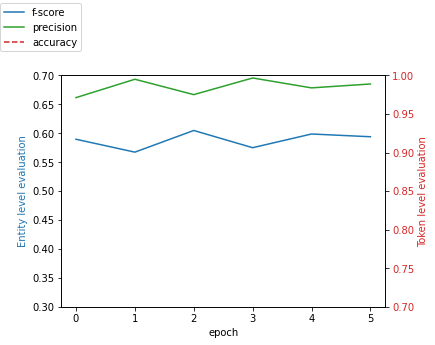

In [83]:

%matplotlib inline

plot_history(evaluation_function.fscore, evaluation_function.precision, evaluation_function.recall) 
## recall doesn't show, it's just a filler param so I didn't have to write the function again
## also, ignore the red axis

In [0]:
#save model and init weights
rnn_model.save('rnn_model_BDAdam001_hid100.h5')

In [87]:
#prediction on test data
m2_predictions = rnn_model.predict(test_vectorized_data_padded)

pred_labels = numpy.argmax(m2_predictions, axis=-1)    #
pprint(pred_labels[2])

array([25,  1, 25, 25,  2,  7, 19, 35, 35, 35, 35, 25, 19, 35, 35, 35, 25,
       19, 35, 35, 35, 35, 25, 25, 25, 25, 25, 19, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25])


## 2.1 Use deep contextual representations

Use deep contextual representations. Fine-tune the embeddings with different hyperparameters. Try different models (e.g. cased and uncased, multilingual BERT). Report your results.


## 2.2 Error analysis

Select one model from each of the previous milestones (three models in total). Look at the entities these models predict. Analyze the errors made. Are there any patterns? How do the errors one model makes differ from those made by another?

## 3.1 Predictions on unannotated text

Use the three models selected in milestone 2.2 to do predictions on the sampled wikipedia text.

## 3.2 Statistically analyze the results

Statistically analyze (i.e. count the number of instances) and compare the predictions. You can, for example, analyze if some models tend to predict more entities starting with a capital letter, or if some models predict more entities for some specific classes than others.